In [1]:
import pandas as pd
import numpy as np

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import scipy.stats as stats
from scipy.stats import  ttest_ind, shapiro, levene, mannwhitneyu
import seaborn as sns
import math

from matplotlib import pyplot as plt
%matplotlib inline

### 0. Auxiliary functions

In [2]:
def test_normality_and_plot(data):
    """
    Performs the Shapiro-Wilk test for normality on the given data.
    Also plots the kernel density estimate (KDE) and Q-Q plot.

    :param data: Data to be tested and plotted (pd.Series or np.array)
    """
    # Perform Shapiro-Wilk Test
    stat, p_value = shapiro(data)
    print(f"Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}")

    # Interpretation
    alpha = 0.05
    if p_value > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

    # Plotting KDE
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.kdeplot(data, fill=True)
    plt.title('Kernel Density Estimate')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title('Q-Q Plot')

    plt.tight_layout()
    plt.show()


In [3]:
def compare_means(control, experiment, alpha=0.05, parametric=True):
    """
    Performs a statistical test to compare means between control and experiment groups.

    :param control: Control group data (pd.Series or np.array)
    :param experiment: Experiment group data (pd.Series or np.array)
    :param alpha: Significance level (default is 0.05)
    :param parametric: Boolean, True for parametric test (t-test), False for non-parametric test (Mann-Whitney U)
    :return: Test statistic, p-value
    """
    if parametric:
        # Perform t-test
        stat, p_value = ttest_ind(control, experiment)
    else:
        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(control, experiment)

    # Decide if the result is significant
    if p_value < alpha:
        print(f"Statistically significant difference found (p = {p_value})")
    else:
        print(f"No statistically significant difference found (p = {p_value})")

    return stat, p_value


### Introduction - What is A/B testing?

A/B testing, also known as split testing, is a method used to compare two versions of a webpage, app feature, or any other product aspect, to determine which one performs better. In its simplest form, A/B testing involves showing version A (the control) to one group and version B (the variant) to another group. By comparing how the two groups respond, we can infer which version is more effective given a pre-defined metric that we use as evaluation.

This approach can help to answer critical questions and hypotheses and reduce guesswork in decision-making. By testing the impact of changes on real users, organizations can optimize their products and services based on actual user responses rather than assumptions, or as mentioned by Kohavi et al on the paper ***Controlled experiments on the web: survey and practical guide***: "Our experience indicates that significant learning and return-on-investment are seen when development teams listen to their customers, not to the Highest Paid Person's Opinion (HiPPO)".

### 1. Problem statement

***Scenario description***

We work for a software company that is looking for ways to increase the number of people who pay for their software. The way that the product is currently offered, users can download and use the software free of charge, for a 7-day trial. After the end of the trial, users are required to pay for a license to continue using it.

An idea that the company wants to evaluate is to change the layout of the homepage to emphasize more prominently that there is a 7-day trial available for the software. The current fear is that some potential users are missing out on using the software because of a lack of awareness of the trial period. If more people download the software and use it in the trial period, the hope is that this will encourage more people to make a purchase after seeing what the software can do.

***Goal of the study***

The first thing we should do is specify the objective or goal of our study:

 - Revising the structure of the homepage will increase the number of people that download the software and, ultimately, the number of people that purchase a license.

***Creating a user funnel***

For A/B tests that are run on web-based applications it is important to map the user journey throughout the website to understand how we can set up experimental condition groups and which metrics make sense to track to measure the experiment's effect. For our use case let's consider that the company's website has 5 main sections:

1. the homepage;
2. a section with additional information, gallery and examples;
3. a page for users to download the software;
4. a page for users to purchase a license; and
5. a support sub-site with documentation and FAQs for the software

For the software itself, the website requires that users create an account in order to download the software program. The software is usable freely for 7 days after download. When the trial period is hit, the program will bring up a dialog box that takes the user to the license page. After purchasing a license, the user will receive a unique code associated with their site account. This code can then be used with the program to register it with that user, allowing it to be used without issue.

### 2. Metrics and user funnel

***Understanding the user funnel***

A most likely flow that a user takes when navigating the website is:

1. Visit homepage
2. Visit download page
3. Signup for an account
4. Download software 
5. After 7-day trial, software takes user to license-purchase page
6. Purchase license

Note that after each step there can be visitors dropping, thus creating a funnel.

![Alt text](user_journey1.png)


*Atypical events*

There are a few events in the expected flow that might not correspond with the visitors we want to target. For example, there might be users on the homepage who aren't new users. Users who already have a license might just be visiting the homepage as a way to access the support sub-site. A user who wants to buy a license might also come in to the license page through the homepage, rather than directly from the software.

When it comes to license purchasing, it's possible that users don't come back after exactly seven days. Some users might come back early and make their purchase during their trial period. Alternatively, a user might end up taking more than seven days to decide to make their purchase, coming back days after the end of the trial. Anticipating scenarios like this can be useful for planning the design, and coming up with metrics that come as close as possible to measuring desired effects.

***Deciding on metrics***

From our user funnel, we should consider two things: where and how we should split users into experiment groups, and what metrics we will use to track the success or failure of the experiment. The choice of unit of diversion (the point at which we divide observations into groups) may affect what metrics we can use, and whether the metrics we record should be considered invariant or evaluation metrics (see definitions of these further below).

The unit of diversion can be one of three possible choices: **event-based**, where with each page view one of the two conditions will be randomly assigned to the visitor. If the condition changes on each pageview, then a visitor might get a different experience on each homepage visit. Event-based diversion is much better when the changes aren't as easily visible to users, to avoid disruption of experience. 

**Account-based** diversion relies on randomly assigning the accounts created by the users to each experimental unit. Since visitors only register after getting to the download page, this is too late to introduce the new homepage to people who should be assigned to the experimental condition.

Finally, we have the **cookie-based diversion** - In this option we assign a cookie to each visitor upon their first page hit, which allows them to be separated into the control and experimental groups. Cookies also allow tracking of each visitor hitting each page, recording whether or not they eventually hit the download page and then whether or not they actually register an account and perform the download. **We will use this option for our use case**

***Experimental groups or Variants*** 

A variant is the equivalent of the user experience that is being assessed (in our case, the change in the homepage layout). A variant is either a control (the status quo) or experimental group.
In our case, the control, or 'A' group, will see the old homepage, while the experimental, or 'B' group, will see the new homepage that emphasizes the 7-day trial.

***Factor***

Is a controllable experimental variable the we believe can influence our evaluation metrics (see definition of evaluation metrics below).

***Invariant metrics***

These are metrics that should not change between the 2 experimental groups and will help us assess the quality of the experiment and do validity checks.
For instance we could track the number of cookies for each section of the website to see if we are getting an equal split in users for the 2 variants.

***Evaluation metric or Overall Evaluation Criterion (OEC)***

Represent measures where you expect there will be differences between groups, and whose differences should say something meaningful about your experimental manipulation.

For that we will use 

1. Download rate (# of downloads / # of cookies) and 
2. License purchase rate (#licenses purchases / # number of cookies).

 The reason for using relative measures instead of absolute ones (we could have simply chosen # of downloads as metric) is that even though we expect the number of cookies assigned to each group to be about the same, it's much more likely than not they they won't be exactly the same due to random fluctuations. Instead, we should prefer using the download rate (# downloads / # cookies) and purchase rate (# licenses / # cookies) relative to the number of cookies as evaluation metrics. Using these ratios allows us to account for slight imbalances between groups that happen due to chance.

 

### 3. Hypothesis testing


***Stating the hypothesis statements***

Null hypothesis (H0): The average download and license purchase rates between the old design and the new design that emphasizes the 7-day trial are the same.

Alternative hypothesis (HA): The average download and license purchase rates between the old design and the new design that emphasizes the 7-day trial are different.

#### Important concepts

***p-value***

Is the probability of finding a result as or more extreme than the observed, given that the modelling assumptions and the null hypothesis are true. Can be expressed in terms of probability as P(value equal or more extreme|H0 is true).

***Significance level (α)***

This is the probability of us commiting a Type I error. That is, that we reject the null hypothesis when it is actually true. We typically set this to 5% (0.05), which means that if after running our statistical test we encounter a p-value of less than 0.05 we reject the null hypothesis and conclude in favor of the alternative. Combining this definition with the p-value definition we can say that there would be a 5% chance of observing a value equal or more extreme than what we are observing, and that we consider this to be very unlikely, therefore rejecting the notion that it is due to chance.

***Statistical Power***

Is the probability of detecting a meaningful difference between the variants when there really is one. In other words, if the null hypothesis is false, this is the probability of correctly rejecting it.

### 4.Experiment Design

***Randomization unit***

It is the experimentation unit that we will randomize. In web-base experiments it is typically the User and in our case it will be too.

***Target population in the experiment***

Users who downloaded the product and went through the 7-day trial period. We are targetting the 2 last levels of the user funnel that we outlined earlier.

***What is our status quo? (H0)***

Now that we have our OECs (evaluation metrics) selected: number of cookies as an invariant metric, and the download rate and license purchase rate (relative to number of cookies), we want to understand if the experiment is feasible in terms of the amount of time it will take to run and sample size needed. 

We can use historical data as a baseline to see what it might take to detect our desired levels of change.

Consider that recent history shows that there are about 3250 unique visitors per day, with slightly more visitors on Friday through Monday, than the rest of the week. There are about 520 software downloads per day (a .16 rate - 520 divided by 3250) and about 65 licenses purchased each day (a .02 rate). In an ideal case, both the download rate and license purchase rate should increase with the new homepage; a statistically significant negative change should be a sign to not deploy the homepage change. However, if only one of our metrics shows a statistically significant positive change we should be happy enough to deploy the new homepage.

***Minimum Detectable Effect (MDE)***

 It refers to the smallest effect size that a test is designed to detect in our evaluation metrics that the test is capable of identifying as statistically significant. It is common practice in industry to work with at least a 5% increase as MDE. 

 MDE is closely linked to the sensitivity of a test. A smaller MDE means the test is more sensitive and can detect smaller differences as significant, but that requires a larger sample size.

 In our case we want to detect an increase of 50 downloads (which leads to a new download rate of 0.175) and 10 license purchases per day (0.023 new rate).
 
 Translating this in terms of our evaluation metrics:

 1. Download rate: we want to detect a change from 0.16 to 0.175
 2. License purchase rate: we want to detect a change from 0.02 to 0.023

A lot of people wonder how they can know the Minimum Detectable Effect (MDE) before they even start their experiment. It's true that we don't know exactly how sensitive our experiment is until we actually do it. But, we usually have an idea of the size of the effect that would be important for us in real-world terms. For instance, it might be okay if we don't notice a tiny change like 0.1% in downloads for our software. But missing a big change like a 5% drop (or increase) in how many people buy a license is a big deal. In this example, a 0.1% change isn't really important, but a 5% change is. Therefore, to estimate the required minimum sample size, we should use the smallest change that practically significant to us. This is what we call the Minimum Detectable Effect.

***Determining the sample size***

For this we can leverage the [NormalIndPower()](https://www.statsmodels.org/devel/generated/statsmodels.stats.power.NormalIndPower.solve_power.html#statsmodels.stats.power.NormalIndPower.solve_power) function from statsmodels

Since we are working with two OECs (evaluation metrics) we need to apply the Bonferroni correction, one of the many type of statistical adjustments that exist when multiple comparisons occur in A/B testing. This correction is important to address the problem of increase in the likelihood of falsely identifying a statistically significant result (also known as a Type I error) when it is actually due to chance when comparing multiple OECs.

To do that we simply divide our α by the number of OECs we are using. In our case, 2. So our new_alpha will be 0.05/2 = 0.025

In [4]:
# We will calculate the sample size required for each OEC
sample_size_downloads = NormalIndPower().solve_power(effect_size = proportion_effectsize(.175, .16), alpha = .025, power = 0.8,
                             alternative = 'larger')

sample_size_licenses = NormalIndPower().solve_power(effect_size = proportion_effectsize(.023, .02), alpha = .025, power = 0.8,
                             alternative = 'larger')

print(f"A sample size of {math.ceil(sample_size_downloads*2)} users will be needed to detect the expected change in effect size for the downloads metrics, whereas {math.ceil(sample_size_licenses*2)} are needed to detect the expected changes in licenses")


A sample size of 19449 users will be needed to detect the expected change in effect size for the downloads metrics, whereas 73300 are needed to detect the expected changes in licenses


Since # cookies = # visitors, to know how many days we need to run the experiment for each scenario we divide the number of users by the average expected number of unique visitors per day (3250)

In [5]:

print(f"The experiment will take {math.ceil(sample_size_downloads*2/3250)} days for the required sample for downloads metrics, and {math.ceil(sample_size_licenses*2/3250)} days for the licenses")


The experiment will take 6 days for the required sample for downloads metrics, and 23 days for the licenses


In web based experiments it is usual to run the experiment for at least 2 or 3 weeks in order to account for 2 common issues that arise: novelty bias and day of the week effect. The first refers to the tendency of users to react differently to changes simply because they are new, not because they are inherently better or worse. In the context of A/B testing, this means that when you introduce a new feature (version B), users might initially engage with it more (or less) just because it's new and different from the standard version (version A). This initial reaction can skew the results of the test.

The day of the week effect in A/B testing acknowledges that user behavior can vary significantly depending on the day of the week. This variation can impact the results of an A/B test if the test doesn't account for these daily fluctuations. For example, suppose you're testing two different layouts for an online store. If the test runs from Monday to Wednesday for version A and from Thursday to Sunday for version B, any observed differences in user engagement or sales might be influenced more by typical weekly shopping patterns (like increased shopping on weekends) rather than the actual differences between the layouts.

**For our experiment, it was decided that it would last 30 days. The tradeoff to be analyzed when defining how long the experiment will take is that we want to be fast - in case we need to pivot the experiment to a different variant analysis - but we don't want to run an underpowered experiment (with smaller sample that theoretically needed) so that we make our decision based on false positives.**

### 5. Analyzing the data

In [6]:
data = pd.read_csv('homepage-experiment-data.csv')

In [7]:
data.head(15)

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses
0,1,1764,246,1,1850,339,3
1,2,1541,234,2,1590,281,2
2,3,1457,240,1,1515,274,1
3,4,1587,224,1,1541,284,2
4,5,1606,253,2,1643,292,3
5,6,1681,287,3,1780,299,3
6,7,1534,262,5,1555,276,8
7,8,1798,331,12,1787,326,20
8,9,1478,223,30,1553,298,38
9,10,1461,236,32,1458,289,23


In [8]:
data.tail(15)

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses
14,15,1822,306,33,1775,300,32
15,16,1463,234,31,1606,279,29
16,17,1573,252,32,1551,295,36
17,18,1603,260,33,1607,281,27
18,19,1596,263,29,1625,289,29
19,20,1817,320,35,1780,315,23
20,21,1602,271,38,1588,256,44
21,22,1743,277,29,1861,341,37
22,23,1631,249,26,1517,272,35
23,24,1489,241,29,1466,279,31


#### Do we have an underpowered experiment?

In [9]:
data['Control Cookies'].sum() + data['Experiment Cookies'].sum()

94197

We needed 73300 samples based on our earlier calculations and we have 94197, therefore we do not have an underpowered experiment.

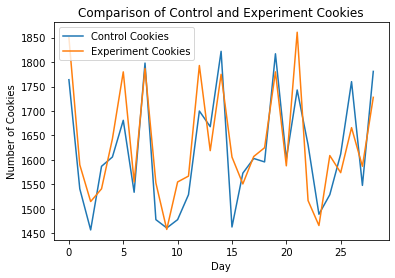

In [10]:
plt.plot(data['Control Cookies'], label = 'Control Cookies')
plt.plot(data['Experiment Cookies'], label = 'Experiment Cookies')

plt.title('Comparison of Control and Experiment Cookies')

# Adding labels to the axes
plt.xlabel('Day')
plt.ylabel('Number of Cookies')

# Optionally, add a legend if you want to label different lines
plt.legend()

# Finally, display the plot
plt.show()

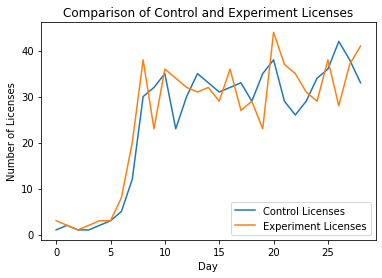

In [11]:
plt.plot(data['Control Licenses'], label = 'Control Licenses')
plt.plot(data['Experiment Licenses'], label = 'Experiment Licenses')

plt.title('Comparison of Control and Experiment Licenses')

# Adding labels to the axes
plt.xlabel('Day')
plt.ylabel('Number of Licenses')

# Optionally, add a legend if you want to label different lines
plt.legend()

# Finally, display the plot
plt.show()

We will consider from day 7 onwards as there seems to be a ramp up in license acquisitions, maybe due to novelty effect.

In [12]:
ab_data = data.copy()

In [13]:
ab_data = ab_data[ab_data['Day'] > 7]

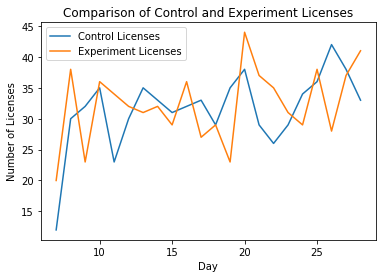

In [14]:
plt.plot(ab_data['Control Licenses'], label = 'Control Licenses')
plt.plot(ab_data['Experiment Licenses'], label = 'Experiment Licenses')

plt.title('Comparison of Control and Experiment Licenses')

# Adding labels to the axes
plt.xlabel('Day')
plt.ylabel('Number of Licenses')

# Optionally, add a legend if you want to label different lines
plt.legend()

# Finally, display the plot
plt.show()

### 5.1. Validity check on the invariant metric

In [15]:
# Extract the relevant columns for A/A testing
control_cookies = ab_data['Control Cookies']
experiment_cookies = ab_data['Experiment Cookies']

Shapiro-Wilk Test: Statistics=0.9203027486801147, p-value=0.07712410390377045
Sample looks Gaussian (fail to reject H0)


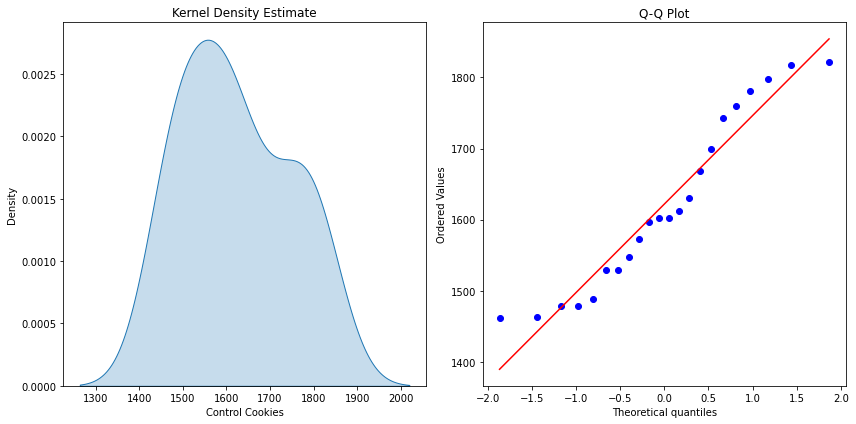

In [16]:
test_normality_and_plot(control_cookies)

Shapiro-Wilk Test: Statistics=0.9254380464553833, p-value=0.09858940541744232
Sample looks Gaussian (fail to reject H0)


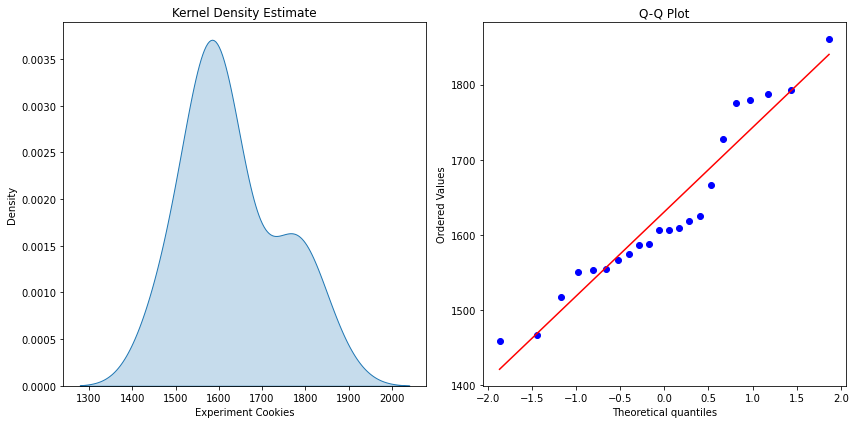

In [17]:
test_normality_and_plot(experiment_cookies)

In [18]:
print(f"Variance of the control group cookies: {np.var(control_cookies)}")
print(f"Variance of the experimental group cookies: {np.var(experiment_cookies)}")

Variance of the control group cookies: 14241.935950413224
Variance of the experimental group cookies: 11747.79338842975


To rigorously check if the variances between two groups are equal, we can use statistical tests that specifically assess the equality of variances. The most commonly used tests for this purpose are the Levene's test and the Bartlett's test. Each has its own strengths and is suitable under different conditions.

For our dataset, we'll first perform Levene's test since it's less sensitive to the assumption of normality. If the p-value is greater than 0.05, we can conclude that there's no significant evidence to suggest the variances are different. If it's less than 0.05, it suggests the variances are significantly different. Let's perform Levene's test on your data.

In [19]:
# Perform Levene's test for equality of variances
levene_stat, levene_p_value = levene(control_cookies, experiment_cookies)

# Display the results of Levene's test
levene_stat, levene_p_value

(0.5577171660069682, 0.4593418805591448)

Since the Levene's test p-value is 0.45 we can conclude that there is no statistical evidence to suggest that the variances of the number of cookies between the control and experiment groups are significantly different. Therefore we can proceed with the t-test, which assumes equal variances between groups. For that we will use Scipy's [ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

In [20]:
# Perform a two-sample t-test
t_stat, p_value = ttest_ind(control_cookies, experiment_cookies)

# Display the t-statistic and p-value
t_stat, p_value

(-0.24678539572997327, 0.8062766059552436)

The results from the two-sample t-test are as follows:

* T-statistic: -0.246

* P-value: 0.806

In the context of an A/A test, these results suggest the following:

1. T-statistic: The t-statistic being close to zero indicates that the mean difference between the two groups is small. A negative value implies that, on average, the experiment group had slightly more cookies, but the magnitude is small.

2. P-value: A p-value of 0.57 is well above the common threshold of 0.05 for statistical significance. This indicates that any observed difference in the number of cookies between the control and experiment groups is likely due to random chance and not due to any systematic difference in how the groups were treated.

Based on these results, we can conclude that the experimental setup is sound for an A/B test, as there is no significant difference in the number of cookies between the two groups in this A/A test scenario. This suggests randomization is effectively in place and no inherent bias in the assignment of visitors to different variants.

### 5.2 Analyzing evaluation metrics

Next, let's calculate our OECs:

1. Download rate (# of downloads / # of cookies) and 
2. License purchase rate (#licenses purchases / # number of cookies).

In [21]:
ab_data['download_rate_control'] = ab_data['Control Downloads'] / ab_data['Control Cookies']
ab_data['download_rate_experiment'] = ab_data['Experiment Downloads'] / ab_data['Experiment Cookies']

ab_data['licenses_rate_control'] = ab_data['Control Licenses'] / ab_data['Control Cookies']
ab_data['licenses_rate_experiment'] = ab_data['Experiment Licenses'] / ab_data['Experiment Cookies']

In [22]:
ab_data.head()

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses,download_rate_control,download_rate_experiment,licenses_rate_control,licenses_rate_experiment
7,8,1798,331,12,1787,326,20,0.184093,0.182429,0.006674,0.011192
8,9,1478,223,30,1553,298,38,0.150880,0.191887,0.020298,0.024469
9,10,1461,236,32,1458,289,23,0.161533,0.198217,0.021903,0.015775
10,11,1478,240,35,1555,279,36,0.162382,0.179421,0.023681,0.023151
11,12,1529,228,23,1567,267,34,0.149117,0.170389,0.015043,0.021698


#### 5.2.1 Checking parametric assumptions

In order to decide if we will use a parametric vs non-parametric stastistical test we need to check the parametric assumptions.

Some points to consider:

1. **Check for Normality**: Use tests like the Shapiro-Wilk or visual inspections (histograms, Q-Q plots). If data is not normally distributed, consider non-parametric tests, especially for small sample sizes.

2. **Assess Variance Homogeneity**: If variances are unequal (check using Levene's or Bartlett's test), non-parametric tests may be more appropriate.

3. **Consider Measurement Scale**: If data are ordinal or nominal, non-parametric tests are typically used.

4. **Sample Size**: For small samples that don't meet parametric assumptions, non-parametric tests are preferable.

5. **Examine Data Characteristics**: Look at skewness, kurtosis, and outliers. Non-parametric tests are more forgiving of these issues.

6. **Specificity of Your Research Question**: If you need precise, quantitative answers, parametric tests are often better, assuming the assumptions are met.

In [23]:
download_rate_control = ab_data['download_rate_control']
download_rate_experiment = ab_data['download_rate_experiment']

Shapiro-Wilk Test: Statistics=0.9810377955436707, p-value=0.9314480423927307
Sample looks Gaussian (fail to reject H0)


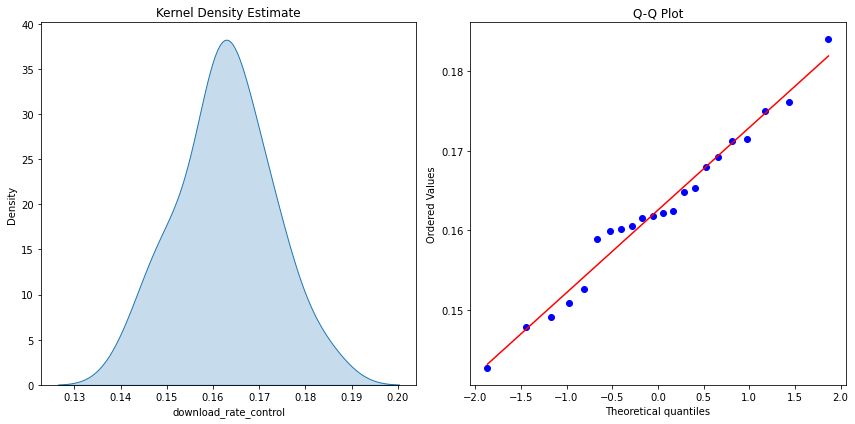

Shapiro-Wilk Test: Statistics=0.9702054262161255, p-value=0.7157924771308899
Sample looks Gaussian (fail to reject H0)


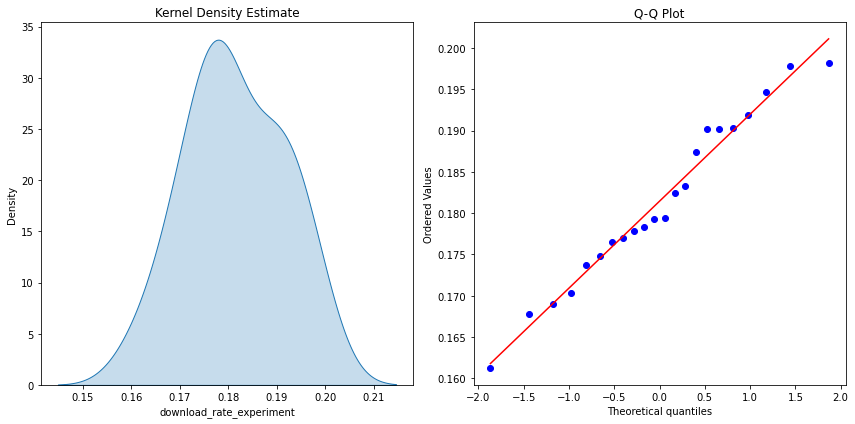

In [24]:
test_normality_and_plot(download_rate_control)
test_normality_and_plot(download_rate_experiment)

In [25]:
# Perform Shapiro-Wilk test for normality
shapiro_control_download_rate = shapiro(download_rate_control)
shapiro_experiment_download_rate = shapiro(download_rate_experiment)

# Display the results for both groups
shapiro_control_download_rate, shapiro_experiment_download_rate

(ShapiroResult(statistic=0.9810377955436707, pvalue=0.9314480423927307),
 ShapiroResult(statistic=0.9702054262161255, pvalue=0.7157924771308899))

In [26]:
# Perform Levene's test for equality of variances
levene_stat, levene_p_value = levene(download_rate_control, download_rate_experiment)

# Display the results of Levene's test
levene_stat, levene_p_value

(0.15184935775638617, 0.6987433399725542)

The data is normally distributed for the download rates, has equal variances and we can assume independence of samples. There we will use a parametric t-test. Let's check for the licenses purchase rate

In [27]:
licenses_rate_control = ab_data['licenses_rate_control']
licenses_rate_experiment = ab_data['licenses_rate_experiment']

Shapiro-Wilk Test: Statistics=0.8689742088317871, p-value=0.007491788826882839
Sample does not look Gaussian (reject H0)


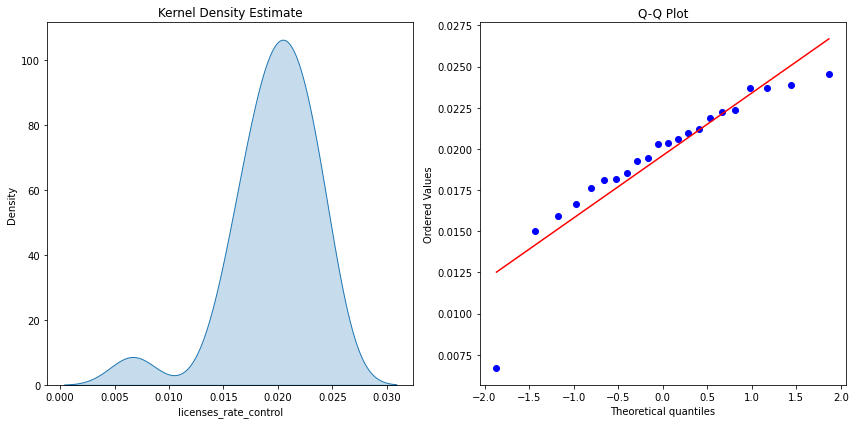

Shapiro-Wilk Test: Statistics=0.964282751083374, p-value=0.5803346633911133
Sample looks Gaussian (fail to reject H0)


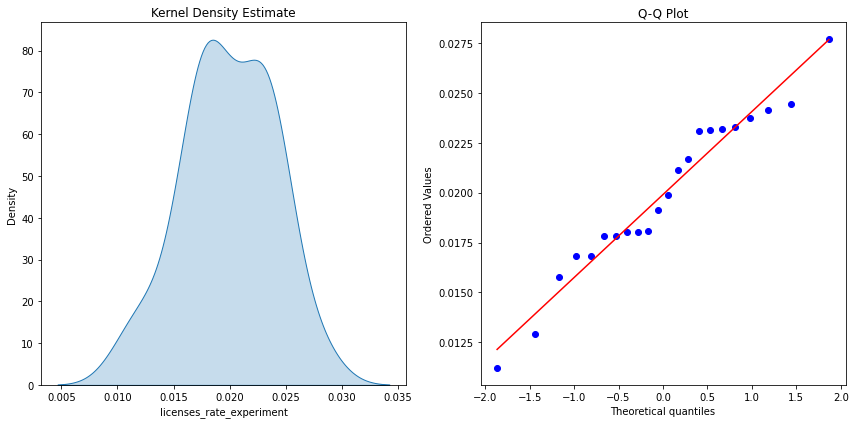

In [28]:
test_normality_and_plot(licenses_rate_control)
test_normality_and_plot(licenses_rate_experiment)

In [29]:
# Perform Shapiro-Wilk test for normality
shapiro_control_download_rate = shapiro(licenses_rate_control)
shapiro_experiment_download_rate = shapiro(licenses_rate_experiment)

# Display the results for both groups
shapiro_control_download_rate, shapiro_experiment_download_rate

(ShapiroResult(statistic=0.8689742088317871, pvalue=0.007491788826882839),
 ShapiroResult(statistic=0.964282751083374, pvalue=0.5803346633911133))

The license purchase rate does not follow a normal distribution for the control group. So we will need to choose a non parametric test for this metric.

#### 5.2 Checking if differences in means are statistically significant

In [30]:
# Download rate
compare_means(download_rate_control, download_rate_experiment, 0.025, True)

Statistically significant difference found (p = 1.8932626551158362e-07)


(-6.223604304633828, 1.8932626551158362e-07)

In [31]:
# Licenses purchasing rate
compare_means(licenses_rate_control, licenses_rate_experiment, 0.025, False)

No statistically significant difference found (p = 0.9719131339533064)


(244.0, 0.9719131339533064)

### 6. Conclusion

Let's recap the goal of our study:
 - Revising the structure of the homepage will increase the number of people that download the software and, ultimately, the number of people that purchase a license.


Our hypotheses were:
1. Null hypothesis (H0): The average download and license purchase rates between the old design and the new design that emphasizes the 7-day trial are the same.

2. Alternative hypothesis (HA): The average download and license purchase rates between the old design and the new design that emphasizes the 7-day trial are different.
 

We found that there was a statistically significant difference in download rates, but not in license purchasing. We can hypothesize that the change we made in our website increases awareness on our product for the 7-day trial but did not contribute to people buying it more. In order to confirm this we would need more data and checking, for example the demographics of people who try out and buy the product to try to understand preferences. Also, when concluding about the results of the experiment it is important to analyze the tradeoff between statistical and practical significance. While statistical significance tells us whether the observed effect in an A/B test is likely not due to random chance, practical significance delves into whether the effect is large enough to be meaningful in a real-world context. For example, if we decide to change the homepage, we have to think about questions like how much will it cost to develop and rollout the changes and if we have the budget for it; what type of resources will it demand; does it align with long-term strategy of the business? And so on. 

In summary, while statistical significance is essential for validating the results of an A/B test, practical significance is key to determining the real-world impact of those results. Balancing these two aspects ensures that the insights gained from A/B testing are both scientifically valid and strategically valuable, leading to more informed and effective decision-making.

